<img src="logo.png" alt="University of Illinois" style="width: 200px;"/>

### Seasonal Error Analysis ###
by: Richard Sowers
* <r-sowers@illinois.edu>
* <https://publish.illinois.edu/r-sowers/>

Copyright 2019 University of Illinois Board of Trustees. All Rights Reserved. Licensed under the MIT license

### Explanation###
This code plots error analysis for Manhattan Traffic Data

imports

In [1]:
import pandas
import numpy
import matplotlib.pylab as plt
%matplotlib inline
import scipy.interpolate
import scipy.optimize 

In [4]:
def saver(fname):
    plt.savefig(fname+".pdf",bbox_inches="tight")
    
params={
    #"font.size":20,
    "figure.titlesize":"large",
    "lines.linewidth":3,
    #"legend.fontsize":"small",
    #"xtick.labelsize":"x-small",
    #"ytick.labelsize":"x-small",
    #"axes.labelsize": 'small',
}
plt.rcParams.update(params) 

constants

In [5]:
colorsequence=['b', 'g', 'r', 'c', 'm', 'y', 'k']
stylesequence=["-",":"]

In [6]:
class processor:
    def __init__(self,df):
        self.rank_vals=pandas.unique(df.index.get_level_values("rank"))
        self.df=df.dropna(axis="index")
        
    def by_penalty(self,rank):
        temp=self.df.groupby(by="rank").get_group(rank)
        return temp.reset_index(level="rank",drop=True)
    
    def sparsity_by_penalty(self,rank):
        temp=self.by_penalty(rank)["sparsity"]
        return temp
    
    def error_by_sparsity(self,rank):
        temp=self.by_penalty(rank)
        temp=temp.set_index(keys="sparsity",drop=True)["error"]
        temp.sort_index(axis="index",inplace=True)
        return temp

In [7]:
class monotone_invert:
    def __init__(self,df,sign="increasing"):
        self.df=df
        self.tvals=numpy.array(self.df.index)
        self.yvals=numpy.array(self.df.to_numpy())
        if len(self.df)<2:
            return None
        self.N=len(self.df)
        self.L=numpy.tril(numpy.ones(shape=(self.N,self.N)),k=0)
        self.ctr=1
        x0=[numpy.mean(self.yvals)/self.N]*self.N
        
        def objective(d):
            error=self.yvals-self.L.dot(d)
            return 0.5*error.dot(error)
        
        def jacobian(self,d): #not used
            error=self.yvals-self.L.dot(d)
            return self.L.T.dot(error)
        
        def hessian(self,d): # not used
            return self.L.T*dot(self.L)
        
        print(self.N)
        pm=1
        if (sign=="decreasing"):
            pm=-1
        constraints={"type":"ineq","fun":lambda x:pm*x}
        res=scipy.optimize.minimize(objective,x0=x0,method="COBYLA",constraints=constraints)
        print(res)
        d_best=res.x
        self.y_approx_vals=self.L.dot(d_best)
        print("y_approx",self.y_approx_vals)
        
        self.linapprox=scipy.interpolate.interp1d(self.tvals,self.y_approx_vals,copy=True,bounds_error=True)
        
    def inc_approx(self,t):
        if not (min(self.tvals)<=t<=max(self.tvals)):
            return numpy.nan
        return self.linapprox(t).item()

        
        tval=scipy.optimize.brentq(lambda x:self.linapprox(x)-yval,min(self.tvals),max(self.tvals))
        return tval

In [8]:
#fname="LevelCurveData2"
fname="fall_values_combined"

read data

In [9]:
data_raw=pandas.read_csv(fname+".csv",na_values=['nan',' nan'])
print(data_raw.head())

   rank    beta   error_year_preAxing   error_year_postAxing  \
0  40.0     0.0             26.638031              41.724601   
1   NaN     NaN                   NaN                    NaN   
2  40.0  1000.0             26.958008              41.843305   
3   NaN     NaN                   NaN                    NaN   
4  40.0  2000.0             26.952959              41.781512   

    error_fall_preAxing   error_fall_postAxing   sparsity_preAxing  \
0             27.410104              42.350878            0.675348   
1                   NaN                    NaN                 NaN   
2             27.733881              42.377424            0.694921   
3                   NaN                    NaN                 NaN   
4             27.722486              42.350216            0.716475   

    sparsity_postAxing  
0             0.838865  
1                  NaN  
2             0.851688  
3                  NaN  
4             0.865042  


In [10]:
data=data_raw.copy()
data.columns=[colname.strip() for colname in data.columns]
data=data.dropna(axis='index',subset=['rank','beta'])
data["rank"]=data["rank"].astype('int')
data=data.set_index(keys=["rank","beta"])
print(data.head())
print(data.columns)

             error_year_preAxing  error_year_postAxing  error_fall_preAxing  \
rank beta                                                                     
40   0.0               26.638031             41.724601            27.410104   
     1000.0            26.958008             41.843305            27.733881   
     2000.0            26.952959             41.781512            27.722486   
     3000.0            26.990673             41.414115            27.758684   
     4000.0            27.039437             41.120108            27.807777   

             error_fall_postAxing  sparsity_preAxing  sparsity_postAxing  
rank beta                                                                 
40   0.0                42.350878           0.675348            0.838865  
     1000.0             42.377424           0.694921            0.851688  
     2000.0             42.350216           0.716475            0.865042  
     3000.0             42.045900           0.730274            0.87252

In [11]:
dataDict={}

In [12]:
data_year=data[["error_year_preAxing","sparsity_preAxing"]]
data_year=data_year.rename(mapper={"error_year_preAxing":"error","sparsity_preAxing":"sparsity"},axis="columns")
data_year.head()
dataDict["year"]=data_year

In [13]:
data_fall=data[["error_fall_preAxing","sparsity_preAxing"]]
data_fall=data_fall.rename(mapper={"error_fall_preAxing":"error","sparsity_preAxing":"sparsity"},axis="columns")
data_fall.head()
dataDict["fall"]=data_fall

In [14]:
pDict={season:processor(dataDict[season]) for season in dataDict.keys()}

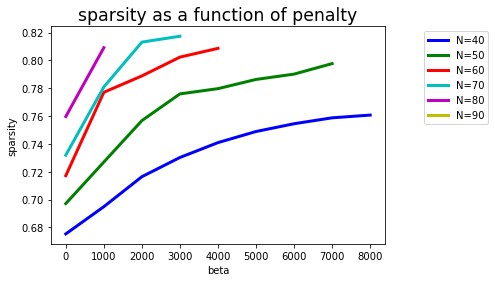

In [15]:
plt.figure()
for n,rank in enumerate(pDict["year"].rank_vals):
    df=pDict["year"].sparsity_by_penalty(rank)
    plt.plot(df.index,df.values,label="N={:}".format(rank),color=colorsequence[n])
plt.legend(bbox_to_anchor=(1.1, 1))
plt.xlabel("beta")
plt.ylabel("sparsity")
plt.title("sparsity as a function of penalty",fontsize="xx-large")
saver("sparsity_by_penalty_seasonal")
plt.show()
plt.close()

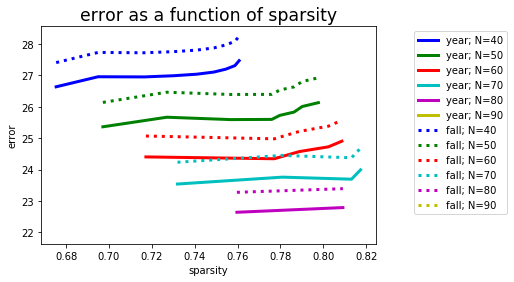

In [16]:
plt.figure()
for n,season in enumerate(dataDict.keys()):
    for nn,rank in enumerate(pDict[season].rank_vals):
        df=pDict[season].error_by_sparsity(rank)
        plt.plot(df.index,df.values,label=season+"; N={:}".format(rank),color=colorsequence[nn],linestyle=stylesequence[n])
plt.legend(bbox_to_anchor=(1.1, 1))
plt.xlabel("sparsity")
plt.ylabel("error")
plt.title("error as a function of sparsity",fontsize="xx-large")
saver("error_by_sparsity_seasonal")
plt.show()
plt.close()

In [17]:
fDict={}
for season in dataDict.keys():
    fDict[season]={rank:monotone_invert(pDict[season].error_by_sparsity(rank)) for rank in pDict[season].rank_vals}

9
     fun: 1.002285454548109e-05
   maxcv: 3.984132841519527e-20
 message: 'Optimization terminated successfully.'
    nfev: 882
  status: 1
 success: True
       x: array([ 2.66360803e+01,  3.20274146e-01, -3.98413284e-20,  3.37122273e-02,
        5.00737280e-02,  6.69419207e-02,  9.36629374e-02,  1.13072493e-01,
        1.56891708e-01])
y_approx [26.63608031 26.95635446 26.95635446 26.99006668 27.04014041 27.10708233
 27.20074527 27.31381776 27.47070947]
8
     fun: 0.0017793033532038684
   maxcv: 6.777965872456384e-20
 message: 'Optimization terminated successfully.'
    nfev: 641
  status: 1
 success: True
       x: array([ 2.53616677e+01,  2.57362306e-01, -6.77796587e-20, -6.41316397e-20,
        1.07285435e-01,  1.05604105e-01,  1.76694575e-01,  1.23591687e-01])
y_approx [25.36166774 25.61903005 25.61903005 25.61903005 25.72631548 25.83191959
 26.00861416 26.13220585]
5
     fun: 0.0008590502468213588
   maxcv: 7.173091025129201e-21
 message: 'Optimization terminated successfull

In [18]:
sparsityvals=numpy.linspace(start=0.68,stop=0.83,num=5)
print(sparsityvals)

[0.68   0.7175 0.755  0.7925 0.83  ]


3
2
2
3
2
2


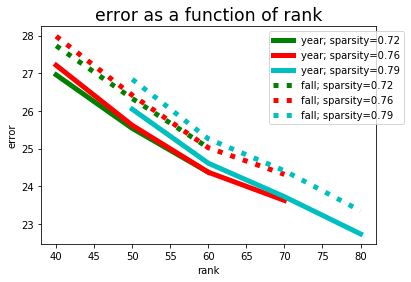

In [47]:
plt.figure()
for n, season in enumerate(dataDict.keys()):
    for nn, sparsity in list(enumerate(sparsityvals)):
        errvals = [fDict[season][rank].inc_approx(sparsity) for rank in pDict[season].rank_vals]
        rankvals = pDict[season].rank_vals
        if sum(map(int, numpy.isnan(errvals))) >= 4:
            continue
        print(sum(map(int, numpy.isnan(errvals))))
        plt.plot(rankvals,
                 errvals,
                 linewidth=5,
                 label=season+"; sparsity={:.2f}".format(sparsity),
                 color=colorsequence[nn],
                 linestyle=stylesequence[n])
plt.legend(bbox_to_anchor=(1.1, 1))
plt.xlabel("rank")
plt.ylabel("error")
plt.title("error as a function of rank",fontsize="xx-large")
saver("error_by_rank_seasonal")
plt.show()
plt.close()